In [1]:
"""
Wine Reviews dataset from Kaggle.com is a dataset built on reviews 
people gave for wines produced in different countries.

Before building deep learning classification it is interesting 
to look into the dataset to get first insights and have some data 
to work with later. 

NLP topics covered in this notebook:
- most frequent relevant words
- class proportionality
- mid description length
- term frequency analysis
- binary classification
- n-gram analysis

"""

'\nWine Reviews dataset from Kaggle.com is a dataset built on reviews \npeople gave for wines produced in different countries.\n\nBefore building deep learning classification it is interesting \nto look into the dataset to get first insights and have some data \nto work with later. \n\nNLP topics covered in this notebook:\n- most frequent relevant words\n- class proportionality\n- mid description length\n- term frequency analysis\n- binary classification\n- n-gram analysis\n\n'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import dataset_preprocessing as dprep

In [3]:
# NUM_TOKEN_PRINT is printing_precision, 
# the number of tokens to be printed for analysis
N_CLASSES = 2 
NUM_TOKEN_PRINT = 15 
NGRAM_RANGE = (1, 3)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 5

kwargs = {
        'norm': None,
        'stop_words': 'english',
        'ngram_range': NGRAM_RANGE,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY
}

In [4]:
# load dataset and preprocess using methods 
# from the project module dataset_preprocessing
reviews = dprep.read_data()
reviews = dprep.clean_descriptions(reviews, False)
reviews = dprep.get_nclass_df(reviews, N_CLASSES)
reviews = dprep.add_splits(reviews, 0.8, 0.1)
train_corpus = reviews[reviews.split == 'train'].description.values

/Users/ksu/projects/github/review_classification/dataset_preprocessing.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  data_df.description = data_df.description.str.replace('[^a-zA-Z\']+', ' ')


In [5]:
# build a vocabulary
vectorizer = CountVectorizer(stop_words='english')
vectorized_texts = vectorizer.fit_transform(train_corpus)
assert len(vectorizer.vocabulary_) != 0

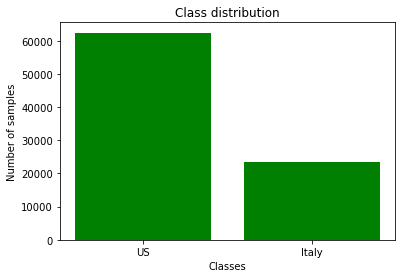

In [6]:
# explore class disproportionality as it affects classification
counts = reviews.country.value_counts().values
classes = reviews.country.unique()
class_0 = classes[0]
# plot the class distribution
plt.figure()
plt.bar(classes, counts, width=.8, color='g')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.show()

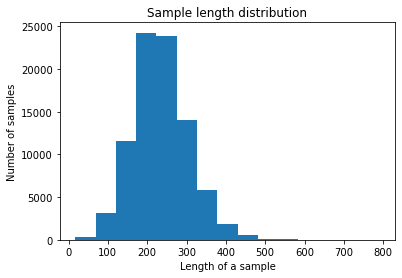

In [7]:
# explore review lengths in the dataset
review_lens = reviews.description.str.len().values
# plot the length disribution
plt.hist(review_lens, NUM_TOKEN_PRINT)
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [8]:
# modify vectorizer by applying tf-idf algorythm
vectorizer = TfidfVectorizer(**kwargs)
x_train = vectorizer.fit_transform(train_corpus).astype('float32')
# binary classification class (1) or not class (0)
y_train = (reviews[reviews.split == 'train'].country == class_0).astype(int).values

max_value = x_train.max(axis=0).toarray().ravel()

sorted_by_tfidf = max_value.argsort()
# print tokens with low importance, frequent
feature_names = np.array(vectorizer.get_feature_names())
print("Feature names with lowest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:NUM_TOKEN_PRINT]]))

# print tokens with high importance, rare
print("Feature names with highest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[-NUM_TOKEN_PRINT:]]))

sorted_by_idf = np.argsort(vectorizer.idf_)
# print frequent over documents tokens
print("Features with lowest idf:\n{}".format(
feature_names[sorted_by_idf[:NUM_TOKEN_PRINT]]))

/Users/ksu/miniforge3/envs/NLP_Projects/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1805: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "


Feature names with lowest tfidf:
['pair' 'crisp acidity' 'spice flavors' 'finishes' 'cherry flavors'
 'blackberry cherry' 'structured' 'buttered toast' 'raspberry cherry'
 'sandalwood' 'smoky oak' 'oak flavors' 'white pepper' 'forest' 'wrapped']
Feature names with highest tfidf:
['horse' 'friulano' 'percent' 'klipsun' 'nero' 'spice mineral' 'banana'
 'monte' 'iron horse' 'walla' 'figgins' 'cailloux' 'nickel' 'partly' 'est']
Features with lowest idf:
['flavors' 'wine' 'fruit' 'cherry' 'tannins' 'aromas' 'finish' 'acidity'
 'dry' 'oak' 'black' 'sweet' 'spice' 'ripe' 'palate']


In [9]:
# fine-tuning inverse regularization parameter
# by trying a range of values and comparing the scores
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(x_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


Best cross-validation score: 0.99
Best parameters:  {'C': 1}


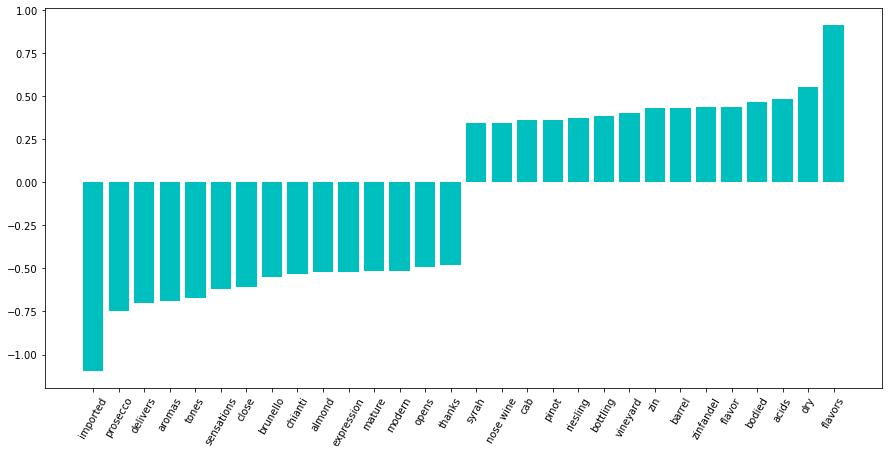

In [10]:
# plot the importance of each token to classification
# below 0 are tokens that contribute to not-class prediction
clf = grid.best_estimator_.fit(x_train, y_train)
coef = clf.coef_.ravel()
list_ = [(n, c) for n, c in zip(feature_names, coef)]
list_ = sorted(list_, key=lambda x: x[1])
list_ = list_[:NUM_TOKEN_PRINT] + list_[-NUM_TOKEN_PRINT:]
#connect all tokens and all coefs for plotting
words, coef = zip(*list_)
idx = np.arange(len(words))
# plot visualisation
plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8, color='c')
plt.xticks(idx, words, rotation=60)
plt.show()

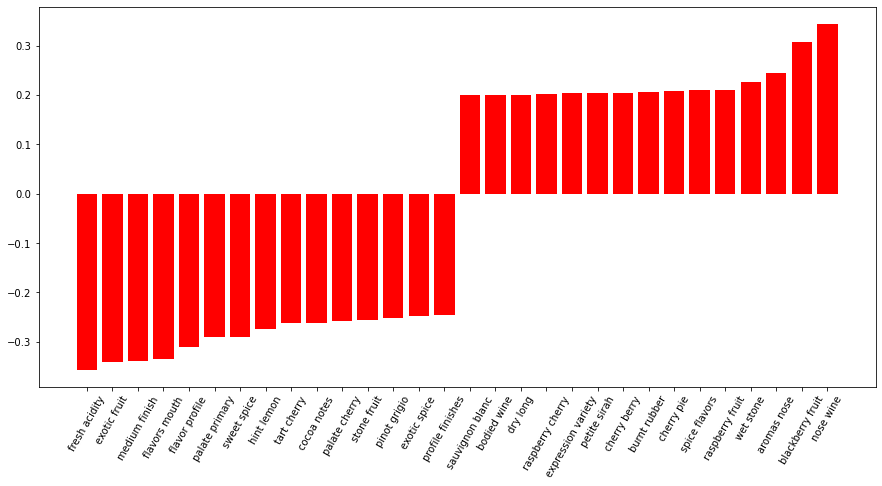

In [11]:
# plot the important bigrams to classification
# choose tokens with length of 2 and corresponding coefs 
# from the list of feature names
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 2
coef = clf.coef_.ravel()[mask]
# combine and sort
list_ = [(n, c) for n, c in zip(feature_names[mask], coef)]
list_ = sorted(list_, key=lambda x: x[1])
list_ = list_[:NUM_TOKEN_PRINT] + list_[-NUM_TOKEN_PRINT:]
# rearrange for plotting
words, coef = zip(*list_)
idx = np.arange(len(words))
# plot bigram importance
plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8, color='r')
plt.xticks(idx, words, rotation=60)
plt.show()

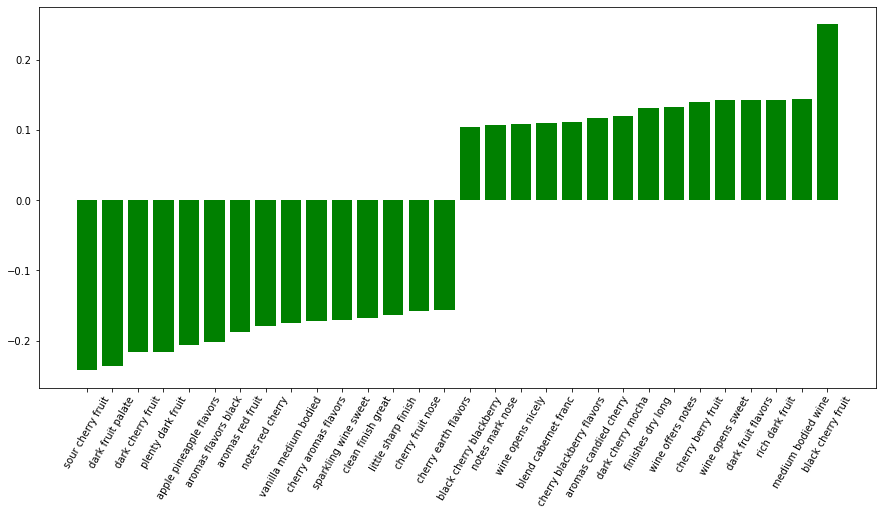

In [12]:
# repeat for 3-grams
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
coef = clf.coef_.ravel()[mask]
list_ = [(n, c) for n, c in zip(feature_names[mask], coef)]
list_ = sorted(list_, key=lambda x: x[1])
list_ = list_[:NUM_TOKEN_PRINT] + list_[-NUM_TOKEN_PRINT:]
words, coef = zip(*list_)
idx = np.arange(len(words))
plt.figure(figsize=(15,7))
plt.bar(idx, coef, width=0.8, color='g')
plt.xticks(idx, words, rotation=60)
plt.show()